### Checking for seasonality

This notebook explains the logic behind the seasonality detection algorithm and **IS NOT INTENDED FOR PRODUCTION**.
It uses the `all_activity_normal.cs` dataset to create trends lines for average advertising budget for the 2009-2018 period. The dataset can be found at `G:\Market\for Matt & B2B\Data\ReachLocal\Platform Data\all_activities 2009-Nov. 2018.zip`.


*Author: Farshad Nasiri - B2B Data Science Team*

In [1]:
# Read the libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

##### The cell below reads and processes the data. For more details on how it works, go to:
https://github.com/GannettDigital/MarketAnalytics/blob/master/RL_churn_Farshad_Greg/budget_trends_in_RL_data.ipynb

In this example, we end up with a trend line for average advertising budgets of K-12 schools.

In [3]:
# Read data
df=pd.read_csv('../data/all_activity_normal.csv')

# Convert the date columns into datetime format
df['Cycle_Started']=pd.to_datetime(df.Cycle_Started)
df['Cycle_Ended']=pd.to_datetime(df.Cycle_Ended)

# Remove the row where there is no start date
df=df[~df.Cycle_Started.isnull()]
df.reset_index(drop=True, inplace=True)

df.drop(columns=['Unnamed: 0'], axis=1, inplace=True) # Drop the first column as it's useless

# Drop some of the columns that we are not looking into at the moment
df.drop(columns=['Primary_BSC_ID', 'BusinessSpecialtyID', 'Advertiser_URL', 'Country','Currency',
       'BusinessSpecialty', 'CPC', 'CTR', 'CPL', 'CTL', 'Paid_On'], axis=1, inplace=True)

df.reset_index(drop=True, inplace=True)

col='Primary_BusinessSubCategory' # Choose a column to look into

df[col].fillna('Other', inplace=True) # Fill in the missing values with "Other"


# Create a temporary table with only the following columns:
# col, 'campaign_budget','Cycle_Started','Cycle_Ended'

temp=df[[col, 'campaign_budget','Cycle_Started','Cycle_Ended']] 
#temp=temp[temp[col]=='Environmental Testing & Cleanup']
names=df[col].unique()
row_size=len(names)

years=range(2009,2019)
col_names=[]
for year in years:
    for quarter in [1,2,3,4]:
        col_names.append(str(year)+'-Q'+str(quarter))


my_df=pd.DataFrame(data=np.zeros((row_size,4*len(years))), columns=col_names)

my_df.index=sorted(names.tolist())


for quarter in range(1,5):
    if quarter==1:
        start_str='-01-01'
        end_str='-03-31'
    if quarter==2:
        start_str='-04-01'
        end_str='-06-30'
    if quarter==3:
        start_str='-07-01'
        end_str='-09-30'
    if quarter==4:
        start_str='-10-01'
        end_str='-12-31'
    
    for year in years:
        start=pd.to_datetime(str(year)+start_str)
        end = pd.to_datetime(str(year)+end_str)

        temp2=temp[(temp.Cycle_Started >= start) & (temp.Cycle_Ended <= end)]
        temp2=temp2.groupby(by=[col]).agg({'campaign_budget':'mean'})
       # print(temp2.shape[0])
        temp2.sort_values(by=[col], inplace=True)
        
        my_col=str(year)+'-Q'+str(quarter)
        my_df.loc[temp2.index, my_col]=temp2.campaign_budget

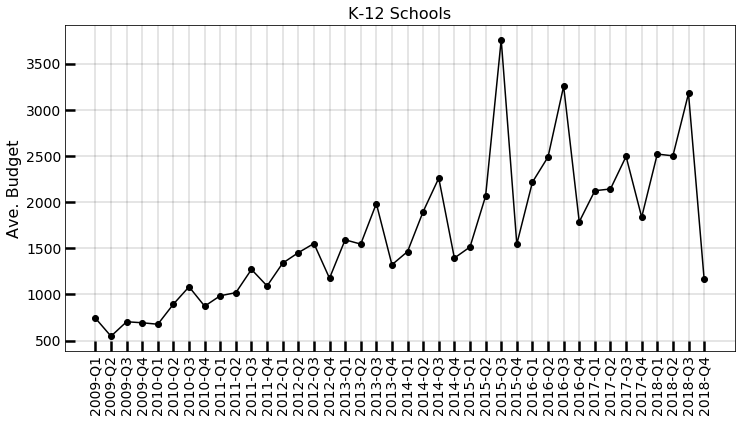

In [4]:
# This is our trend line:
time_series=my_df.loc['K-12 Schools',:].values

time_series=time_series.reshape(1,-1)

# Plot the time series (trend line)
plt.figure(figsize=(12,6))
plt.cla() # Clear the plot area
plt.plot(my_df.columns,time_series[0],'k-o') # Plot the line
plt.xticks(rotation='vertical'); # Rotate the labels on the x-axis
plt.tick_params(direction='in', length=10, width=2.5, colors='k',
                grid_color='k', grid_alpha=1, labelsize=14) # Customize the axes
plt.grid(b=True, linewidth=0.2) # Turn on the grid
plt.title('K-12 Schools', fontsize=16) # Set plot title
plt.ylabel('Ave. Budget', fontsize=16); # Set y-axis title

There is a peak at every Q3. As you'd expect the period is 4 quarters (a year).
The algorithm that detects this seasonality works as follows:

- Perform a moving average of the series and subtract it from the series to remove the trend (in this case there is an increasing trend).
- Perform a Fast Fourier Transform (FFT) on the new series. The FFT window should be the next power of 2 larger than the number of data points. Here we have 40 (10 years x 4 quarters) so the window is 64.
- Calculate the absolute square of the FFT. This is called the power spectrum.
- Create the half frequency range: ```freq_ts=(np.linspace(0,nfft/2,int(nfft/2)) *Fs/float(nfft))``` where `Fs` is the sampling frequency which for our example is one quarter so Fs=1. Note: When doing FFT, the resulting array has a lenght of $2 \times FFT_{window}$ and it's symmetrical  with respect to the mid-point. Therefore we only need the first half of it hence the 	_half_ frequency range.
- Plot the bar plot of power spectrum against frequency. At dominant frequencies, you'll see a spike.

In [7]:
# Define a function that calculates moving average

def ma(array, window=1):
    return np.convolve(array[0], np.ones((1,window))[0]/window, mode='same').reshape(1,array.shape[1])

In [8]:
# Calculate the moving average and remove it from the time series 

mov_avg=ma(time_series, window=4)
time_series=time_series-ma(time_series, window=4)

In [9]:
nfft=1<<(time_series.shape[1]-1).bit_length() # Next largest power of 2

# Perform FFT
y=np.fft.fft(time_series, n=nfft)
y=abs(y**2) # Get the power spectrum

# Scale (optional)
y=(y-y.min())
y=y/y.max()

# Reshaping because Python is stupid and doesn't take care of this 
# automatically. Boy I miss Matlab.
y=y[0][0:int(nfft/2)].reshape(1,-1).T

# Create frequency half range
freq_ts=(np.linspace(0,nfft/2,int(nfft/2)) *1/float(nfft))
freq_ts=freq_ts.reshape(1,-1).T


C:\Users\FNasiri\AppData\Local\Continuum\anaconda3\lib\site-packages\mkl_fft\_numpy_fft.py:158: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.fft(a, n, axis)


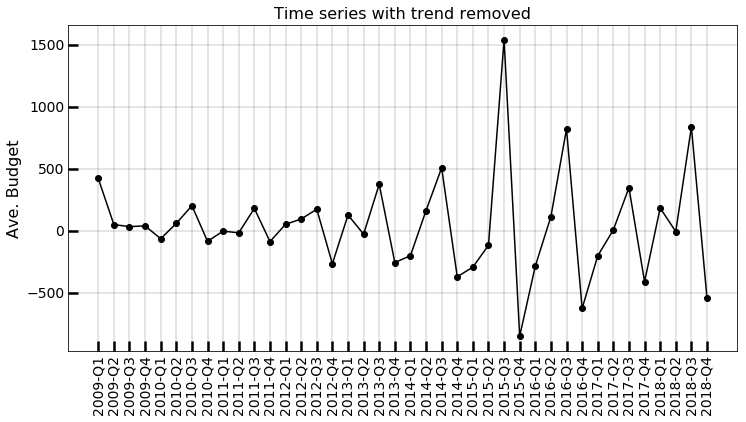

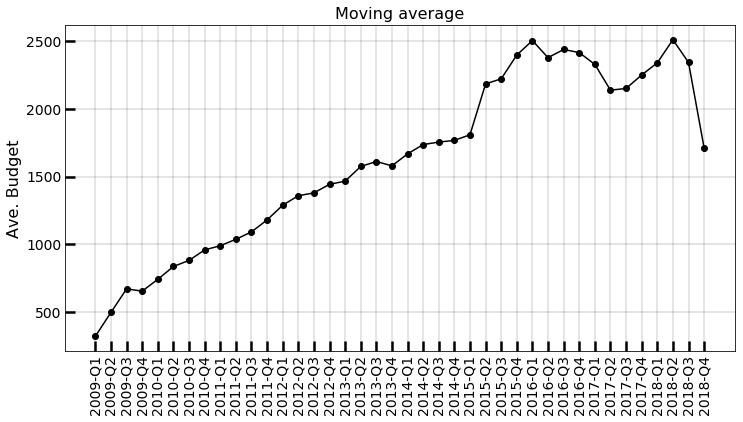

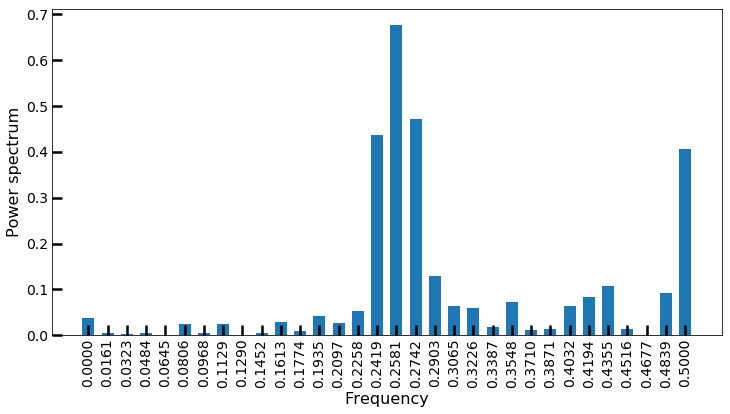

In [13]:
# Plot every thing

plt.figure(figsize=(12,6))
plt.cla()
plt.plot(my_df.columns,time_series[0],'k-o')
plt.xticks(my_df.columns,rotation='vertical');
plt.tick_params(direction='in', length=10, width=2.5, colors='k',
                           grid_color='k', grid_alpha=1, labelsize=14)
plt.grid(b=True, linewidth=0.2)
plt.ylabel('Ave. Budget', fontsize=16)
plt.title('Time series with trend removed', fontsize=16)


plt.figure(figsize=(12,6))
plt.cla()
plt.plot(my_df.columns,mov_avg[0],'k-o')
plt.xticks(my_df.columns,rotation='vertical');
plt.tick_params(direction='in', length=10, width=2.5, colors='k',
                           grid_color='k', grid_alpha=1, labelsize=14)
plt.grid(b=True, linewidth=0.2)
plt.ylabel('Ave. Budget', fontsize=16)
plt.title('Moving average', fontsize=16)


plt.figure(figsize=(12,6))
plt.cla()
plt.bar(freq_ts.T[0],y.T[0], width=0.01)
plt.xticks(ticks=freq_ts.T[0],rotation='vertical');
#plt.yscale('log')
plt.tick_params(direction='in', length=10, width=2.5, colors='k',
                           grid_color='k', grid_alpha=1, labelsize=14)
plt.ylabel('Power spectrum', fontsize=16);
plt.xlabel('Frequency', fontsize=16);

The largest power is at $f=0.2581$ which corresponds to a period of $p=\frac{1}{f}=3.874$ which is close to 4 (quarters) or a year.

The next step is to define a prcedure to detect this without the need to visually inspect the power spectrum. In the case of a time series where there is no seasonality (imagine random noise), there would be no dominant frequency. As a result the power spectrum features no spikes and looks more or less uniform. If you ran a linear regression line through the frequency vs. power plot, it'll be almost horizontal; in other words, the slope would be small. We use this to detect if a signal is seasonla or not. If the absolute value of the regression line slop is larger than a certain threshold, then the signal is seasonal. If not, it isn't.

In [15]:
from sklearn.linear_model import LinearRegression # Import linear regression

In [17]:
mdl=LinearRegression() # Instantiate the model.
mdl.fit(freq_ts, y) # Fit the model

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [18]:
mdl.coef_ # Get the slope

array([[0.2533072]])

It's fairly large. By trial and error, I have found 0.01 to be a good threshold.